# Packages and helper functions for creating graph of cities in Europe

In [13]:
import geopy

from geopy.geocoders import Nominatim
from geopy import distance

geolocator = Nominatim(user_agent="robbe.claeys@gmail.com")

def limit_locations_EU(locations):
    lat_min, lat_max = 35.8, 72
    long_min, long_max = -11, 36
    return [location for location in locations if lat_min <= location.latitude <= lat_max and long_min <= location.longitude <= long_max][0]

def get_country_long_lat(city):
    locations = geolocator.geocode(city, exactly_one=False)
    # print(locations)
    if len(locations) > 1:
        location = limit_locations_EU(locations)
        # print(location)
    else:
        location = locations[0]
    country = location.address.split(",")[-1].strip()
    return (country, location.latitude, location.longitude)

def get_distance(geo1, geo2):
    return distance.distance(geo1, geo2).km

get_country_long_lat("Praha")

('Česko', 50.0596288, 14.446459273258009)

In [14]:
def time_to_minutes(time):
    hours, minutes = time.split(":")
    return int(hours) * 60 + int(minutes)

time_to_minutes("8:30")

510

In [15]:
import pandas as pd

airport = pd.read_csv("./data/airports.csv")
airport = airport[airport["type"] == "large_airport"]
airport = airport[airport["continent"] == "EU"]

def is_airport(geo_city, geo_airport, max_distance=40):
    distance = get_distance(geo_city, geo_airport)
    if distance <= max_distance:
        return True

def get_airport(lat, long):
    geo_city = (lat, long)
    for i, row in airport.iterrows():
        geo_airport = (row["latitude_deg"], row["longitude_deg"])
        if is_airport(geo_city, geo_airport):
            return row["iata_code"]
        
    return None

# Manually created list of cities in Europe and their connections

In [16]:
cities = [
    # Ireland
    "Westport","Belfast","Dublin","Cork",
    # Londonderry, Dundalk, Sligo, Ballina, Athlone, Athenry, Galway,
    # Limerick, Ballyprophy, Dun Laoghaire, Limerick Junction, Kilkenny,
    # Tralee, Killarney, Mallow, Waterford, Wexford, Rosslare Harbour,

    # UK
    "Aberdeen","Glasgow","Edinburgh","York","London","Holyhead","Birmingham","Bristol","Penzance",

    # Belgium
    "Brussels",

    # Netherlands
    "Amsterdam",

    # France
    "Paris","Rennes","Lyon","Bordeaux","Montpellier","Hendaye","Marseille","Nice",

    # Spain
    "Madrid","Barcelona","Valencia","Pamplona","Santander","Santiago","Sevilla","Vigo", "Granada", "Malaga",

    # Portugal
    "Lisbon","Porto","Faro",

    # Italy
    "Rome", "Milan", "Genova", "Bologna", "Firenze", "Napoli","Bari", "Catania", "Venezia",

    # Switzerland
    "Zurich","Basel","Bern",

    # Germany
    "Köln","Hamburg", "Berlin", "München", "Frankfurt", 

    # Chec republic - Tsjechie
    "Praha",

    # Denmark
    "Copenhagen","Aarhus",

    # Sweden
    "Stockholm","Kiruna","Östersund",

    # Norway
    "Oslo","Bergen","Trondheim","Bodø",

    # Finland
    "Helsinki","Turku","Rovaniemi",

    # Estonia - Estland
    "Tallinn","Narva", "Tartu", "Viljandi", "Valga",

    # Latvia - Letland
    "Riga","Daugavpils","Liepaja",

    # Lithuania - Litouwen
    "Vilnius","Kaunas","Klaipeda","Trakai",

    # Poland
    "Warsaw","Krakow","Gdansk","Katowice","Przemysl","Poznan",

    # Austria - Oostenrijk
    "Wien",

    # Slovenia
    "Ljubljana",

    # Croatia
    "Zagreb","Split",

    # Hungary
    "Budapest",
    
    # Serbia
    "Belgrade",

    # Montenegro
    "Bar",

    # North Macedonia
    "Skopje",

    # Romania
    "Bucharest", "Cluj-Napoca", "Craiova",

    # Bulgaria
    "София", "Варна",

    # Greece
    "Αθήνα", "Θεσσαλονίκη", "Πάτρα",

    # Turkey
    "Istanbul", "Ankara", "Eskisehir", "Konya",
]

In [17]:
rails = [
    ("Cork", "Dublin", 165),
    ("Dublin", "Belfast", 130),
    ("Dublin", "Westport", 190),

    ("Dublin", "Holyhead", 195, "ferry"),

    ("Aberdeen", "Edinburgh", 140),
    ("Edinburgh", "Glasgow", 50),
    ("Edinburgh", "York", 155),
    ("Edinburgh", "Birmingham", 260),
    ("Glasgow", "Birmingham", 290),
    ("Holyhead", "London", 230),
    ("Birmingham", "London", 85),
    ("York", "London", 110),
    ("Bristol", "London", 95),
    ("Penzance", "London", 305),

    ("London", "Brussels", 155),
    ("London", "Paris", 170),
    ("Brussels", "Paris", 85),

    ("Paris", "Rennes", 130),
    ("Paris", "Bordeaux", 195),
    ("Bordeaux", "Lyon", 375),
    ("Montpellier", "Marseille", 115),
    ("Marseille", "Nice", 155),
    ("Lyon", "Marseille", 100),
    ("Bordeaux", "Hendaye", 180),

    ("Paris", "Barcelona", 390),
    ("Montpellier", "Barcelona", 180),
    ("Hendaye", "Madrid", 380),

    ("Madrid", "Barcelona", 150),
    ("Madrid", "Pamplona", 180),
    ("Madrid", "Santander", 270),
    ("Madrid", "Santiago", 310),
    ("Madrid", "Valencia", 100),
    ("Madrid", "Sevilla", 140),
    ("Madrid", "Malaga", 145),
    ("Madrid", "Granada", 195),
    ("Barcelona", "Valencia", 190),
    ("Barcelona", "Sevilla", 330),
    ("Santiago", "Vigo", 90),

    ("Vigo", "Porto", 140),
    ("Porto", "Lisbon", 160),
    ("Lisbon", "Faro", 180),

    ("Nice", "Genova", 295),
    ("Lyon", "Bern", 230),
    ("Paris", "Basel", 185),
    ("Paris", "Frankfurt", 235),

    ("Bern", "Zurich", 56),
    ("Basel", "Bern", 58),
    ("Basel", "Frankfurt", 165),

    ("Bern", "Milan", 180),
    ("Zurich", "Milan", 195),
    ("Milan", "Genova", 98),
    ("Milan", "Venezia", 155),
    ("Milan", "Bologna", 60),
    ("Bologna", "Firenze", 35),
    ("Bologna", "Bari", 320),
    ("Firenze", "Rome", 90),
    ("Rome", "Genova", 245),
    ("Rome", "Napoli", 65),
    ("Rome", "Bari", 240),
    ("Catania", "Napoli", 450),

    ("Venezia", "Ljubljana", 390),
    ("Venezia", "München", 450),
    ("Venezia", "Wien", 460),
    ("Milan", "München", 450),
    ("Wien", "München", 240),
    ("Wien", "Zurich", 600),

    ("München", "Zurich", 210),
    ("München", "Frankfurt", 200),
    ("München", "Berlin", 270),
    ("München", "Hamburg", 360),
    ("München", "Praha", 360),
    ("Berlin", "Praha", 245),
    ("Berlin", "Hamburg", 100),
    ("Berlin", "Köln", 260),
    ("Berlin", "Frankfurt", 235),
    ("Amsterdam", "Köln", 158),
    ("Brussels", "Köln", 110),
    ("Frankfurt", "Köln", 65),
    ("Frankfurt", "Hamburg", 220),
    ("Frankfurt", "Brussels", 190),

    ("Amsterdam", "Brussels", 110),
    ("Amsterdam", "Hamburg", 315),

    ("Wien", "Ljubljana", 360),
    ("Wien", "Praha", 240),
    ("Wien", "Budapest", 160),
    ("Praha", "Budapest", 405),
    ("Ljubljana", "Zagreb", 140),
    ("Ljubljana", "Budapest", 585),
    ("Zagreb", "Split", 360),
    ("Zagreb", "Budapest", 400),

    ("Hamburg", "Aarhus", 265),
    ("Hamburg", "Copenhagen", 280),

    ("Stockholm", "Copenhagen", 300),
    ("Oslo", "Copenhagen", 450),
    ("Oslo", "Stockholm", 360),
    ("Oslo", "Bergen", 405),
    ("Oslo", "Trondheim", 390),
    ("Trondheim", "Bodø", 570),
    ("Östersund", "Trondheim", 220),
    ("Östersund", "Stockholm", 305),
    ("Stockholm", "Kiruna", 975),

    ("Rovaniemi", "Helsinki", 510),
    ("Turku", "Helsinki", 120),

    ("Tallinn", "Stockholm", 960, "ferry"),
    ("Tallinn", "Helsinki", 120, "ferry"),
    ("Stockholm", "Riga", 1020, "ferry"),


    ("Tallinn", "Narva", 135),
    ("Tallinn", "Viljandi", 115),
    ("Tallinn", "Tartu", 115),
    ("Tartu", "Valga", 80),

    ("Valga", "Riga", 260),
    ("Riga", "Liepaja", 67),
    ("Riga", "Daugavpils", 200),

    ("Vilnius", "Klaipeda", 240),
    ("Vilnius", "Kaunas", 80),
    ("Vilnius", "Trakai", 33),
    ("Vilnius", "Daugavpils", 160),

    ("Kaunas", "Warsaw", 480),

    ("Warsaw", "Gdansk", 160),
    ("Warsaw", "Poznan", 180),
    ("Gdansk", "Poznan", 190),
    ("Warsaw", "Katowice", 130),
    ("Warsaw", "Krakow", 130),
    ("Berlin", "Poznan", 165),
    ("Berlin", "Katowice", 365),
    ("Krakow", "Katowice", 65),

    ("Krakow", "Przemysl", 190),
    ("Katowice", "Praha", 320),
    ("Katowice", "Wien", 268),

    ("Budapest", "Cluj-Napoca", 400),
    ("Budapest", "Bucharest", 900),
    ("Budapest", "Craiova", 660),
    ("Budapest", "Belgrade", 485),
    ("Budapest", "Warsaw", 680),

    ("Bucharest", "Cluj-Napoca", 570),
    ("Bucharest", "Craiova", 400),
    ("Bucharest", "Варна", 525),
    ("Bucharest", "София", 565),
    ("Bucharest", "Belgrade", 730),

    ("София", "Craiova", 510),
    ("София", "Belgrade", 530),
    ("София", "Istanbul", 580),
    ("София", "Θεσσαλονίκη", 440),
    ("София", "Skopje", 540),

    ("Belgrade", "Skopje", 590),
    ("Belgrade", "Bar", 500),

    ("Skopje", "Θεσσαλονίκη", 300),
    ("Αθήνα", "Θεσσαλονίκη", 263),
    ("Αθήνα", "Πάτρα", 180),

    ("Istanbul", "Eskisehir", 150),
    ("Ankara", "Eskisehir", 90),
    ("Ankara", "Konya", 110),

    ("Πάτρα", "Bari", 930, "ferry"),
    ("Barcelona", "Genova", 1020, "ferry"),
    ("Belfast", "Glasgow", 195, "ferry"),
]

# Create graph of cities in Europe

- Coordinates of cities are fetched
- Nearby airports are fetched
- Connections between cities are created with distances and other features

In [18]:
import networkx as nx
import pickle
from networkx.utils import open_file


try:
    # open local graph
    @open_file(0, mode="rb")
    def pickle_load(path):
        return pickle.load(path)

    G = pickle_load("./data/cities.gpickle")


except:
    # create new graph
    G = nx.Graph()

    for city in cities:
        print(city)
        country, lat, long = get_country_long_lat(city)
        airport_code = get_airport(lat, long)

        G.add_node(
            city,                       # node name
            country=country,            # country
            lat=lat,                    # latitude
            long=long,                  # longitude
            iata_code=airport_code,     # airport code
            weight=1                    # weight (desire to visit)
            )

    # save networkx graph locally (avoid API calls to Nominatim geocoder)
    @open_file(1, mode="wb")
    def write_gpickle(G, path, protocol=pickle.HIGHEST_PROTOCOL):
        pickle.dump(G, path, protocol)

    write_gpickle(G, "./data/cities.gpickle")


G.nodes(data=True)

NodeDataView({'Westport': {'country': 'Éire / Ireland', 'lat': 53.8000645, 'long': -9.520218, 'iata_code': None, 'weight': 1}, 'Belfast': {'country': 'United Kingdom', 'lat': 54.596391, 'long': -5.9301829, 'iata_code': 'BFS', 'weight': 1}, 'Dublin': {'country': 'Éire / Ireland', 'lat': 53.3493795, 'long': -6.2605593, 'iata_code': 'DUB', 'weight': 1}, 'Cork': {'country': 'Éire / Ireland', 'lat': 51.897077, 'long': -8.4654674, 'iata_code': None, 'weight': 1}, 'Aberdeen': {'country': 'United Kingdom', 'lat': 57.1482429, 'long': -2.0928095, 'iata_code': None, 'weight': 1}, 'Glasgow': {'country': 'United Kingdom', 'lat': 55.861155, 'long': -4.2501687, 'iata_code': 'GLA', 'weight': 1}, 'Edinburgh': {'country': 'United Kingdom', 'lat': 55.9533456, 'long': -3.1883749, 'iata_code': 'EDI', 'weight': 1}, 'York': {'country': 'United Kingdom', 'lat': 53.9590555, 'long': -1.0815361, 'iata_code': None, 'weight': 1}, 'London': {'country': 'United Kingdom', 'lat': 51.4893335, 'long': -0.144055084527687

In [19]:
for rail in rails:
    print(rail)
    node1 = G.nodes[rail[0]]
    geo1 = (node1['lat'], node1['long'])
    node2 = G.nodes[rail[1]]
    geo2 = (node2['lat'], node2['long'])

    dist = get_distance(geo1, geo2)

    if rail[-1] == "ferry":
        rail_type = "ferry"
    elif rail[-1] == "reservation":
        rail_type = "reservation"
    else:
        rail_type = "rail"
    
    G.add_edge(
        rail[0], rail[1],
        distance=dist,
        time=rail[2],
        type=rail_type
    )

# print edges with their features
G.edges(data=True)

('Cork', 'Dublin', 165)
('Dublin', 'Belfast', 130)
('Dublin', 'Westport', 190)
('Dublin', 'Holyhead', 195, 'ferry')
('Aberdeen', 'Edinburgh', 140)
('Edinburgh', 'Glasgow', 50)
('Edinburgh', 'York', 155)
('Edinburgh', 'Birmingham', 260)
('Glasgow', 'Birmingham', 290)
('Holyhead', 'London', 230)
('Birmingham', 'London', 85)
('York', 'London', 110)
('Bristol', 'London', 95)
('Penzance', 'London', 305)
('London', 'Brussels', 155)
('London', 'Paris', 170)
('Brussels', 'Paris', 85)
('Paris', 'Rennes', 130)
('Paris', 'Bordeaux', 195)
('Bordeaux', 'Lyon', 375)
('Montpellier', 'Marseille', 115)
('Marseille', 'Nice', 155)
('Lyon', 'Marseille', 100)
('Bordeaux', 'Hendaye', 180)
('Paris', 'Barcelona', 390)
('Montpellier', 'Barcelona', 180)
('Hendaye', 'Madrid', 380)
('Madrid', 'Barcelona', 150)
('Madrid', 'Pamplona', 180)
('Madrid', 'Santander', 270)
('Madrid', 'Santiago', 310)
('Madrid', 'Valencia', 100)
('Madrid', 'Sevilla', 140)
('Madrid', 'Malaga', 145)
('Madrid', 'Granada', 195)
('Barcelona',

EdgeDataView([('Westport', 'Dublin', {'distance': 221.65498106188807, 'time': 190, 'type': 'rail'}), ('Belfast', 'Dublin', {'distance': 140.48032254660674, 'time': 130, 'type': 'rail'}), ('Belfast', 'Glasgow', {'distance': 176.7736994006666, 'time': 195, 'type': 'ferry'}), ('Dublin', 'Cork', {'distance': 220.01032785775706, 'time': 165, 'type': 'rail'}), ('Dublin', 'Holyhead', {'distance': 108.51153693036997, 'time': 195, 'type': 'ferry'}), ('Aberdeen', 'Edinburgh', {'distance': 149.13760853210707, 'time': 140, 'type': 'rail'}), ('Glasgow', 'Edinburgh', {'distance': 67.19474201927635, 'time': 50, 'type': 'rail'}), ('Glasgow', 'Birmingham', {'distance': 406.34898330364024, 'time': 290, 'type': 'rail'}), ('Edinburgh', 'York', {'distance': 259.79096534258827, 'time': 155, 'type': 'rail'}), ('Edinburgh', 'Birmingham', {'distance': 395.6212686448407, 'time': 260, 'type': 'rail'}), ('York', 'London', {'distance': 282.030790768852, 'time': 110, 'type': 'rail'}), ('London', 'Holyhead', {'dista

# Plot graph of cities in Europe

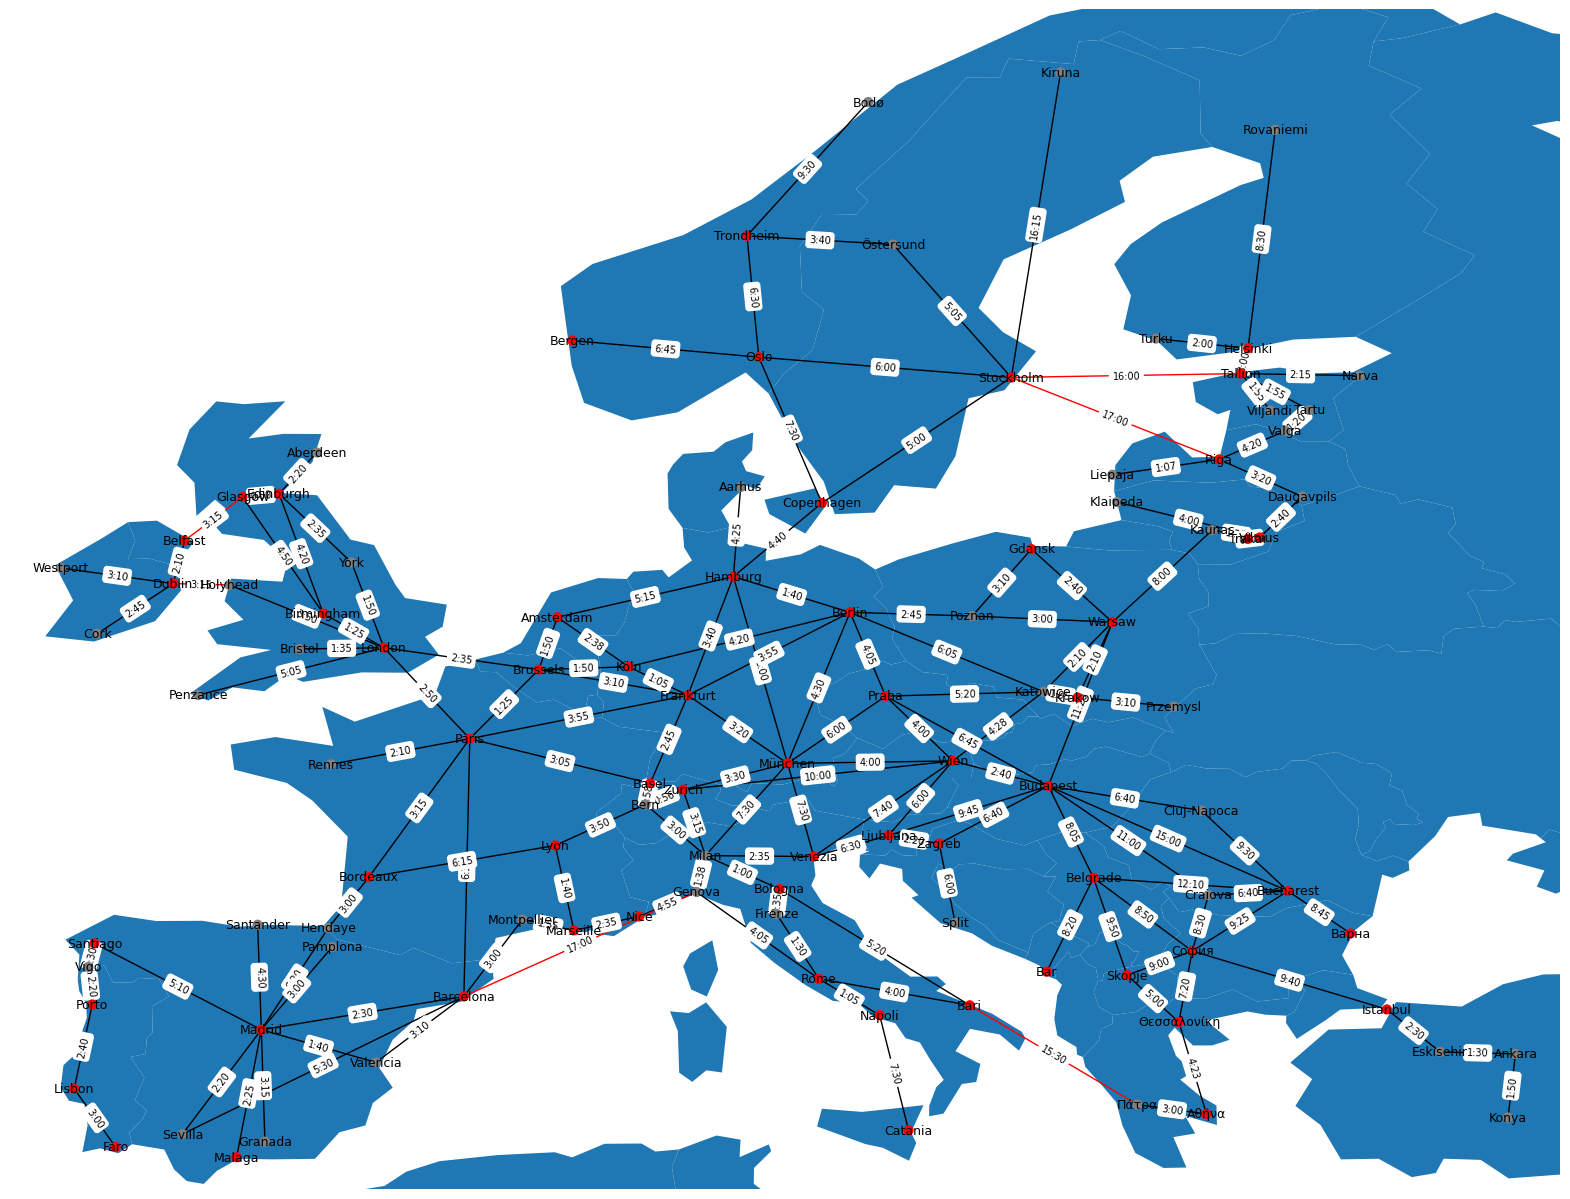

In [24]:
# plot graph using longitude and latitude features of nodes as x and y coordinates
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import contextily as cx

def plot_graph(G, paths=None, weight="time", figsize=(20, 16)):
    pos = {city: (data["long"], data["lat"]) for city, data in G.nodes(data=True)}

    # add background map
    # world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = gpd.read_file("./data/map/ne_110m_admin_0_countries.shp")
    ax = world.plot(figsize=(20, 16))
    ax.set_xlim(-11, 34)
    ax.set_ylim(35.8, 70)

    # color nodes grey if they have no airport "iata_code"
    node_colors = ["red" if data["iata_code"] else "grey" for city, data in G.nodes(data=True)]

    # color edges red if they are a ferry
    edge_colors = ["red" if data["type"] == "ferry" else "black" for u, v, data in G.edges(data=True)]

    # add edge feature "time" in format hh:mm to the plot
    edge_labels = {(u, v): f"{data['time']//60}:{data['time']%60:02d}" for u, v, data in G.edges(data=True)}

    nx.draw(G, pos, with_labels=True, node_size=40, font_size=9, node_color=node_colors, edge_color=edge_colors, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)

    # add paths to the plot
    if paths:
        for path in paths:
            edges = list(zip(path, path[1:]))
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="pink", width=2, ax=ax)

    plt.show()

plot_graph(G)

Total time from Brussels to Istanbul: 39h 30m


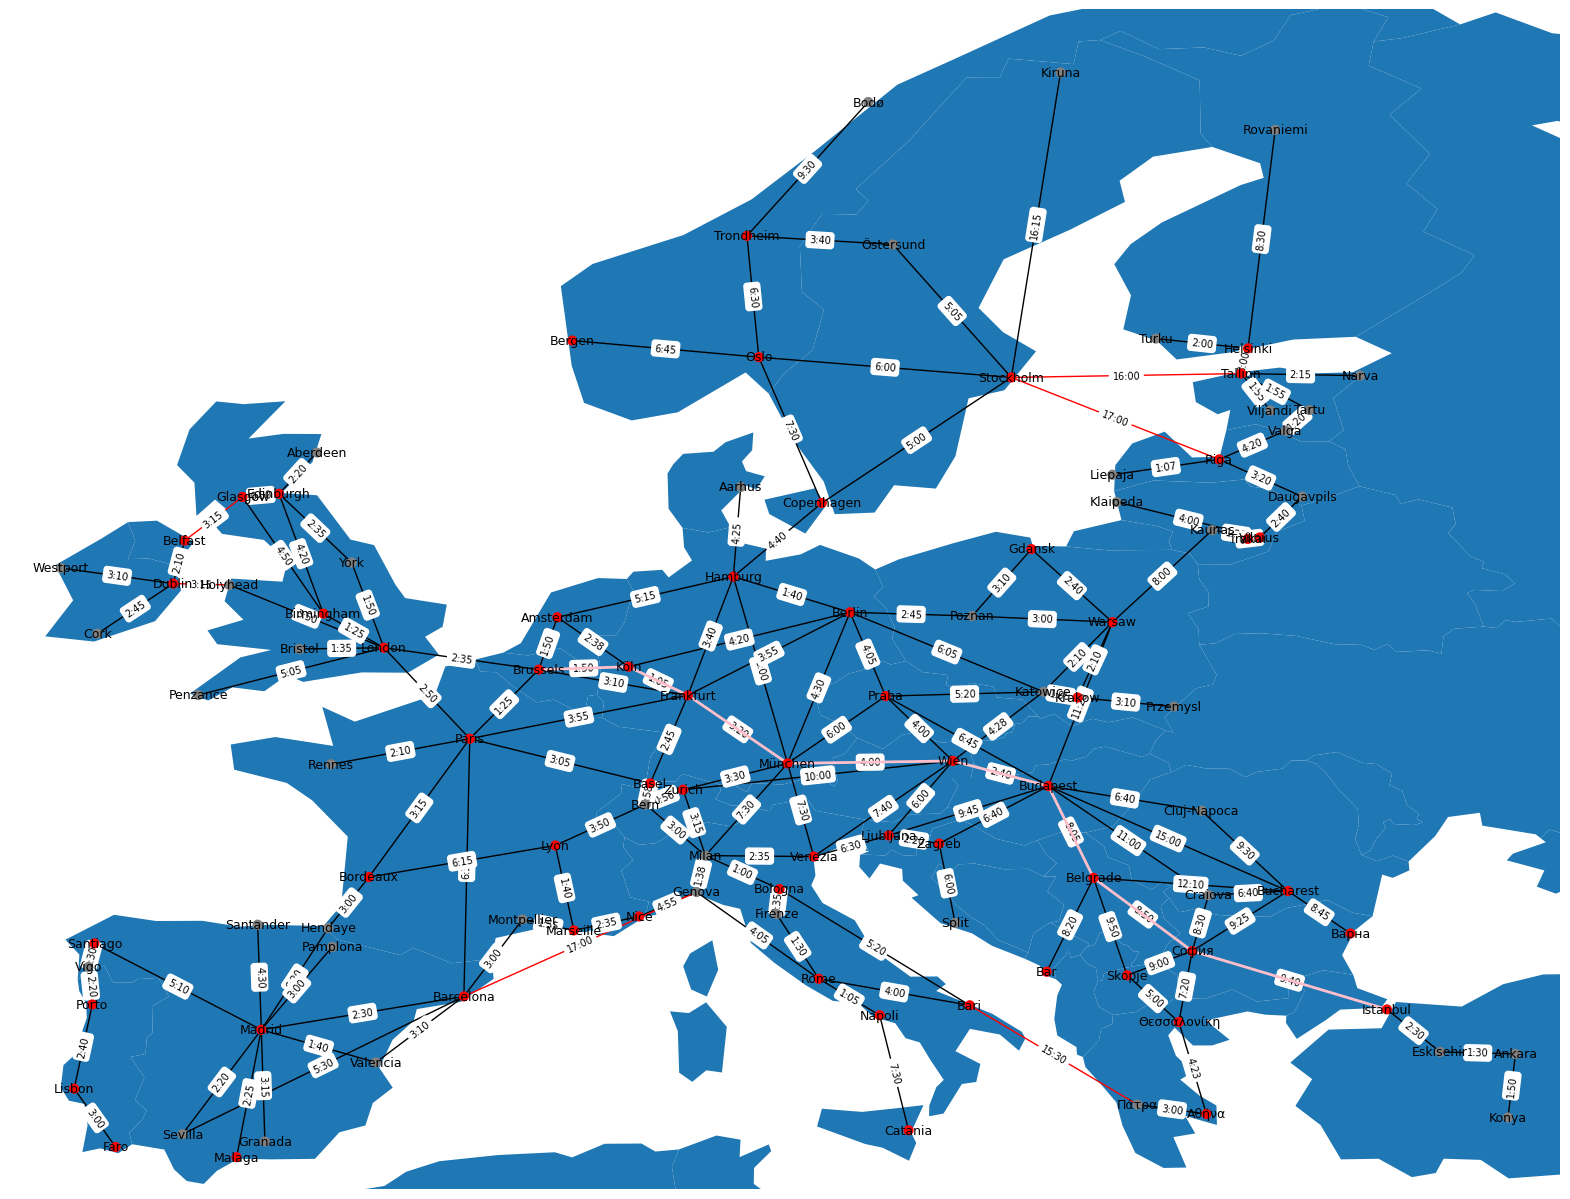

In [25]:
# shortest path from Brussels to Istanbul
path = nx.shortest_path(G, source="Brussels", target="Istanbul", weight="time")

# draw path on map
time_sum = [G.edges[path[i], path[i+1]]["time"] for i in range(len(path)-1)]
print(f"Total time from Brussels to Istanbul: {sum(time_sum)//60}h {sum(time_sum)%60}m")
plot_graph(G, paths=[path])